# AIML339 Assignment 3
## Matrix Profiles for Anomaly Detection and Time Series Dynamics

The matrix profile is primarily used to find repeating patterns and outliers in a single, univariate time series.. This is based on the principle of similarity joins - comparing a sub-sequence of the time series against itself, by computing the distance between each pair of subsequences. Matrix profile algorithms have the following properties:
- Domain agnostic
- Can be exact or approximate
- Only one hyperparameter (window length)
- Parallelizable
- Stream compatible
- Handles missing data

## Terms:
- **Motif**: A repeated pattern in the time series.
- **Discord**: An anomaly in the time series.




In [8]:
import pandas as pd
import numpy as np
import stumpy
from stumpy import config
from numba import cuda
import matplotlib.pyplot as plt
from helpers import plot_features, plot_detection, evaluate_predictions

### Load the Datasets
Datasets used:
- GenSyn (synthetic electricity prices)
- Electricity Authority Point of Connection WWD1102

In [2]:
gensyn_raw    = pd.read_csv(r"data/GenSyn2122.csv", parse_dates=[[0, 1]])
gensyn_labels = pd.read_csv(r"data/GenSyn_labels2122.csv")
poc_raw    = pd.read_csv(r"data/2024-08-10_2025-08-10_pocWWD1102_WWD1103.csv")

/tmp/ipykernel_12846/840461730.py:1: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  gensyn_raw    = pd.read_csv(r"data/GenSyn2122.csv", parse_dates=[[0, 1]])
/tmp/ipykernel_12846/840461730.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  gensyn_raw    = pd.read_csv(r"data/GenSyn2122.csv", parse_dates=[[0, 1]])


In [3]:
gensyn = pd.concat([gensyn_raw, gensyn_labels], axis=1)
gensyn["time"] = pd.to_datetime(gensyn["year_day_of_year"], format="%Y %j")
gensyn["year"] = pd.to_datetime(gensyn["year_day_of_year"], format="%Y %j").dt.strftime("%Y").astype(int)
gensyn["day_of_year"] = pd.to_datetime(gensyn["year_day_of_year"], format="%Y %j").dt.strftime("%j").astype(int)
gensyn = gensyn.rename(columns={"energy_usage": "energy", "anomaly_label": "label"})

In [20]:
poc = (poc_raw
    .where(poc_raw["PointOfConnection"] == "WWD1102")
    .groupby(["TradingDate", "TradingPeriod"], as_index=False)
    .agg({
        "DollarsPerMegawattHour": "mean"
    })[["DollarsPerMegawattHour", "TradingDate", "TradingPeriod"]]
)

# Join onto a complete list of start times (every half hour) to ensure no missing values

data_start = min(poc["TradingDate"])
data_end = max(poc["TradingDate"])

dates_df = pd.DataFrame(pd.date_range(start=data_start, end=data_end), columns=["TradingDate"])
periods = pd.DataFrame(range(1, 48+1), columns=["TradingPeriod"])
dates_df = dates_df.join(periods, how="cross")

dates_df["TradingDate"] = dates_df["TradingDate"].dt.date
poc["TradingDate"] = pd.to_datetime(poc["TradingDate"]).dt.date
poc["date_time"] = pd.to_datetime(poc["TradingDate"]) + pd.to_timedelta((poc["TradingPeriod"] - 1) * 30, unit="m")
poc = pd.merge(poc, dates_df, how="left", on=["TradingDate", "TradingPeriod"])
poc["year"] = pd.to_datetime(poc["TradingDate"], format="%Y-%m-%d").dt.strftime("%Y").astype(int)
poc["day_of_year"] = pd.to_datetime(poc["TradingDate"], format="%Y-%m-%d").dt.strftime("%j").astype(int)
poc = poc.rename(columns={"DollarsPerMegawattHour": "energy"})

poc.head()

,energy,TradingDate,TradingPeriod,date_time,year,day_of_year
0,831.943333,2024-08-10,1.0,2024-08-10 00:00:00,2024,223
1,818.933333,2024-08-10,2.0,2024-08-10 00:30:00,2024,223
2,827.310000,2024-08-10,3.0,2024-08-10 01:00:00,2024,223
3,805.053333,2024-08-10,4.0,2024-08-10 01:30:00,2024,223
4,808.931667,2024-08-10,5.0,2024-08-10 02:00:00,2024,223


In [9]:
# cuda acceleration
gpus = [device.id for device in cuda.list_devices()]

### Functions for testing & evaluating

In [81]:
def find_anomalies(df, col, windows, k=3, exclude_nearby=True, gpu=None, series=None):
    if series is None:
        series = df[col].values

    n = len(series)
    results = {}

    for w in windows:
        if gpu is not None:
            mp = stumpy.gpu_stump(series, m=w, device_id=gpu)
        else:
            mp = stumpy.stump(series, m=w)

        profile = mp[:, 0]

        padded_profile = np.full(n, np.nan)
        padded_profile[w-1:] = profile

        if exclude_nearby:
            anomaly_indices, anomaly_scores = topk_anomalies_with_exclusion(profile, k, w)
        else:
            anomaly_indices = np.argsort(profile)[-k:]
            anomaly_scores = profile[anomaly_indices]

        mask = np.ones(n, dtype=int)
        for idx in anomaly_indices:
            l = idx
            r = idx + w
            print(f"w = {w}; from {l} to {r}")
            mask[l:r] = -1

        results[w] = {
            "profile": padded_profile,
            "indices": anomaly_indices,
            "scores": anomaly_scores,
            "mask": mask
        }

    return results

def topk_anomalies_with_exclusion(profile, k, w):
    profile = profile.copy()
    anomaly_indices = []
    anomaly_scores = []

    for _ in range(k):
        # find best remaining index
        idx = np.nanargmax(profile)  # largest value
        score = profile[idx]

        anomaly_indices.append(idx)
        anomaly_scores.append(score)

        l = max(0, idx - w)
        r = min(len(profile), idx + w)
        profile[l:r] = -np.inf   # or np.nan if you prefer

    return np.array(anomaly_indices), np.array(anomaly_scores)

def explanatory_plot(signal, mp):

    fig, ax = plt.subplots(figsize=(12,5))

    ax.plot(signal, label="signal")
    ax.plot(mp[m]["profile"], label="matrix profile")

    ax2 = ax.twinx()
    ax2.set_ylim(-1, 1)
    ax2.get_yaxis().set_visible(False)

    mask = mp[m]["mask"]

    x = np.arange(len(mask))

    ax2.fill_between(x, -1, 1, where=(mask == -1),
                     color="red", alpha=0.3)

    plt.legend()

    return plt

## Choice of Window Size
How does changing the subsequence length (e.g., 24 hours, 48 hours, 168 hours) affect which anomalies are discovered?

First, I opted to visualise applying the matrix profile with window size `w = 10`.

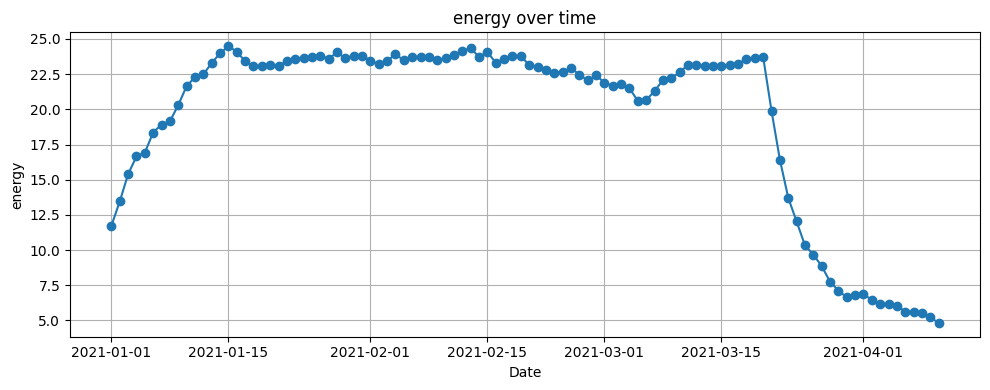

In [10]:
plot_features(gensyn, start_day=1, end_day=100, start_year=2021, end_year=2021, features=["energy"])

In [230]:
mp = stumpy.gpu_stump(gensyn["energy"], m=5, device_id=gpus)

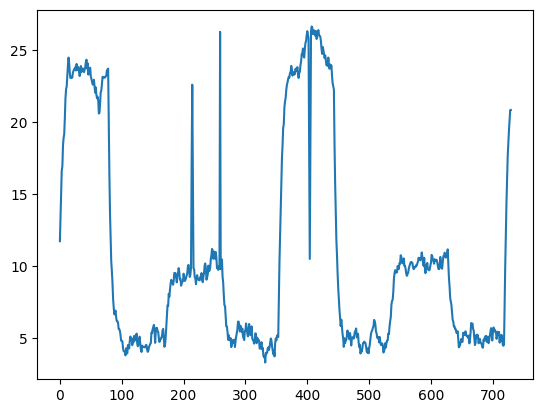

In [197]:
plt.plot(gensyn["energy"])

In [224]:
anom = find_anomalies(gensyn, "energy", [3, 5, 7, 10], gpu=gpus)

w = 3; from 433 to 436
w = 3; from 428 to 431
w = 3; from 520 to 523
w = 5; from 432 to 437
w = 5; from 224 to 229
w = 5; from 344 to 349
w = 7; from 256 to 263
w = 7; from 305 to 312
w = 7; from 290 to 297
w = 10; from 302 to 312
w = 10; from 131 to 141
w = 10; from 669 to 679


In [170]:
anom[3]

{'profile': array([           nan,            nan, 1.52514535e-03, 8.69665694e-03,
        2.84018182e-03, 1.31205533e-02, 5.77671341e-03, 9.43164929e-03,
        1.31205533e-02, 3.30899555e-03, 9.75729833e-05, 1.01831454e-02,
        1.83719749e-03, 1.51386541e-03, 2.70994361e-03, 4.51600108e-02,
        7.52111497e-03, 1.43448752e-03, 8.03486578e-03, 1.14482312e-03,
        5.50399148e-04, 1.52612870e-03, 5.77671341e-03, 8.70132533e-05,
        1.30415841e-03, 6.74760018e-03, 3.69727363e-03, 2.68216125e-02,
        5.50399148e-04, 1.60460183e-02, 3.94713131e-03, 7.58024350e-04,
        1.11692611e-03, 5.85604929e-03, 2.05450076e-04, 3.08983358e-02,
        7.25240406e-03, 4.80102935e-04, 1.66295235e-02, 1.27127390e-02,
        1.03795991e-02, 4.09115029e-03, 1.42147781e-04, 1.63847152e-03,
        2.54641589e-02, 8.43288733e-03, 7.64744041e-03, 4.15590199e-03,
        1.38510017e-04, 1.20940156e-03, 3.20264495e-04, 5.38063845e-03,
        1.21150418e-03, 9.32090232e-04, 1.23267424e-0

In [153]:
np.argwhere(gensyn["label"] == -1)

array([[ 28],
       [ 29],
       [ 30],
       [199],
       [213],
       [214],
       [215],
       [259],
       [278],
       [279],
       [280],
       [403],
       [404],
       [405],
       [463],
       [464],
       [465],
       [574]])

In [179]:
anomalies_gensyn_true = gensyn["label"]

evaluate_predictions(gensyn["label"], anom[5]["mask"])

| Model | Recall | Precision | Correct | Missed | False Positives |
|-------|--------|-----------|---------|--------|------------------|
| unnamed | 0.056 | 0.067 | 1 | 17 | 14 |


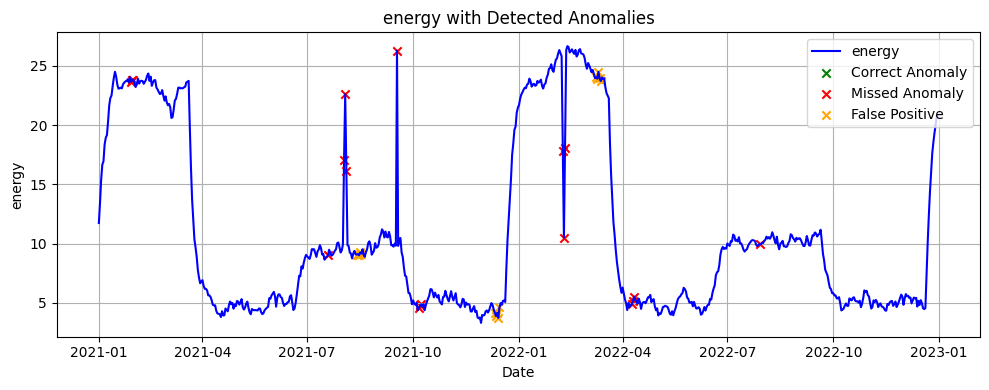

In [235]:
plot_detection(df=gensyn, y_true=gensyn["label"], y_pred=anom[5]["mask"], start_day=1, start_year=2021, end_day=730, end_year=2023, feature="energy")

In [110]:
anom[0][1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [112]:
np.array(gensyn["label"])

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

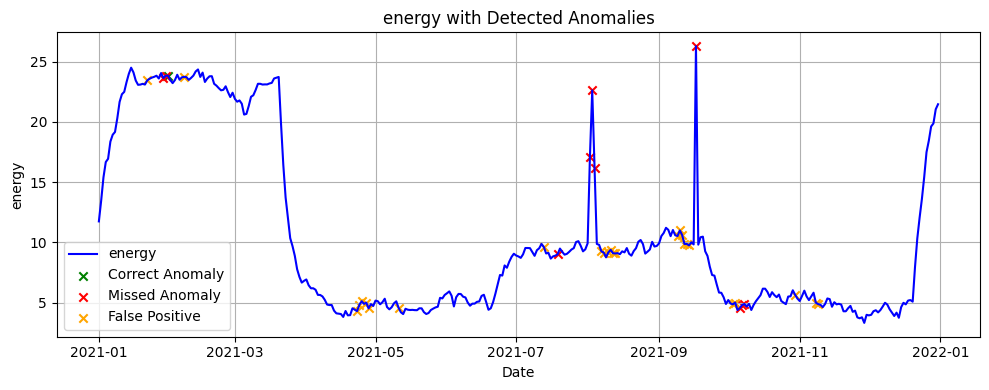

In [124]:
plot_detection(df=gensyn, y_true=gensyn["label"], y_pred=anom[3][1], start_day=1, start_year=2021, end_day=400, end_year=2021, feature="energy")

In [41]:
print(np.sort(np.array(profiles[0]), axis=1)[:10])

[[-1 0.0015251453491208478 237 237]
 [-1 0.008696656936546449 598 598]
 [0 0.002840181816322727 163 163]
 [0 0.013120553315350378 6 6]
 [0.005776713407557531 2 20 20]
 [0.009431649294092135 2 20 20]
 [0.013120553315350378 3 3 361]
 [0 0.0033089955492239457 64 64]
 [9.757298327597203e-05 5 461 461]
 [0.010183145378331896 4 386 386]]


In [42]:
np_mat = np.array(profiles[0])

In [49]:
np.max(np_mat[:, 0])

0.07097117761897134

array([135, 125, 258, 410, 588])

array([0.07097117761897134, 520, 520, 648], dtype=object)